### IMPORTACIÓN DE PAQUETES

In [ ]:
!pip install yfinance
import yfinance

In [ ]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import warnings
warnings.filterwarnings("ignore")
sns.set()

### DATA

In [ ]:
data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", end = "2019-09-01", 
                              interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)
df=data.copy()

[*********************100%***********************]  4 of 4 completed


In [ ]:
df['spx'] = df['^GSPC'].Close[:]
df['dax'] = df['^GDAXI'].Close[:]
df['ftse'] = df['^FTSE'].Close[:]
df['nikkei'] = df['^N225'].Close[:]

In [ ]:
df = df.iloc[1:]
del df['^N225']
del df['^GSPC']
del df['^GDAXI']
del df['^FTSE']
df=df.asfreq('b')
df=df.fillna(method='ffill')

In [ ]:
df['ret_spx'] = df.spx.pct_change(1).mul(100)
df['ret_ftse'] = df.ftse.pct_change(1).mul(100)
df['ret_dax'] = df.dax.pct_change(1).mul(100)
df['ret_nikkei'] = df.nikkei.pct_change(1).mul(100)

In [ ]:
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]

### MODELO

In [ ]:
!pip install pmdarima

In [ ]:
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Crear Fechas (business days)
start_date = "2014-07-16"
end_date = "2015-01-01"

#### AUTOREGRESIVO

##### ESTACIONARIEDAD

In [ ]:
from pmdarima.arima.utils import ndiffs

ndiffs(df.ret_ftse[1:], test = "pp")

0

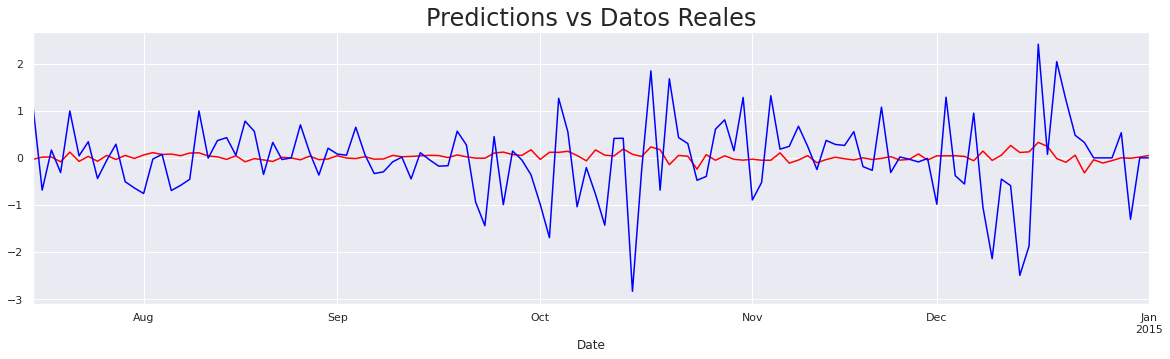

In [ ]:
model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Datos Reales Retornos", size = 24)
plt.show()

#### MEDIA MOVIL

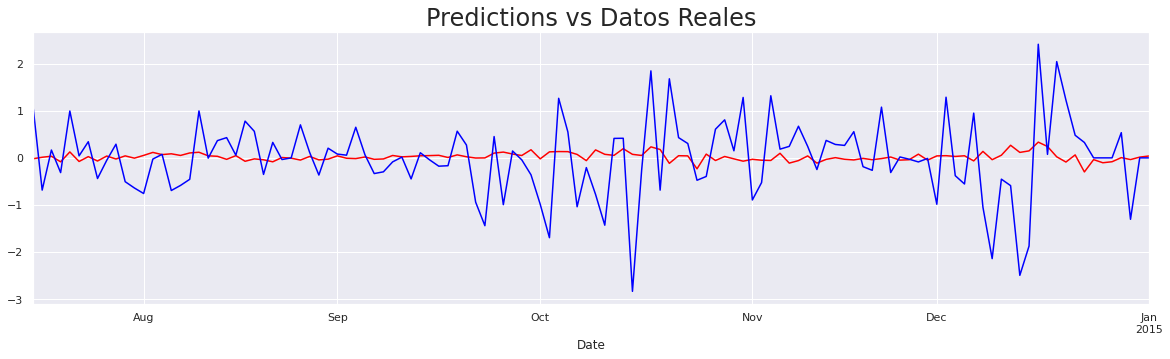

In [ ]:
#end_date = "2015-01-01"
model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,5))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Datos Reales", size = 24)
plt.show()

#### ARIMA

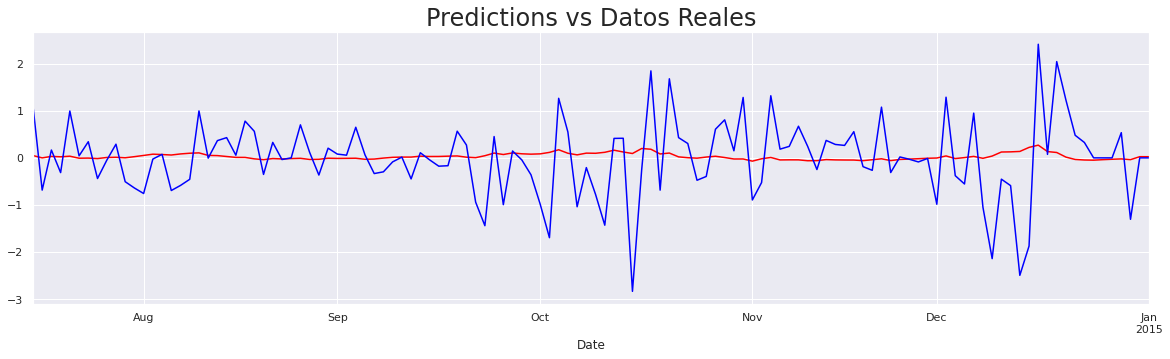

In [ ]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Datos Reales", size = 24)
plt.show()

#### ARIMAX

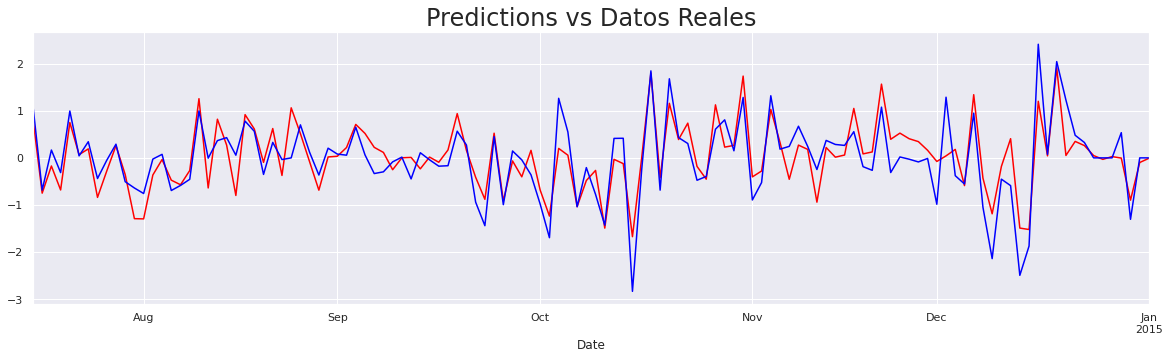

In [ ]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Datos Reales", size = 24)
plt.show()

#### SARIMA

##### ESTACIONALIDAD

In [ ]:
from pmdarima.arima.utils import nsdiffs

nsdiffs(df.ret_ftse[1:],test='ch', m=5)

0

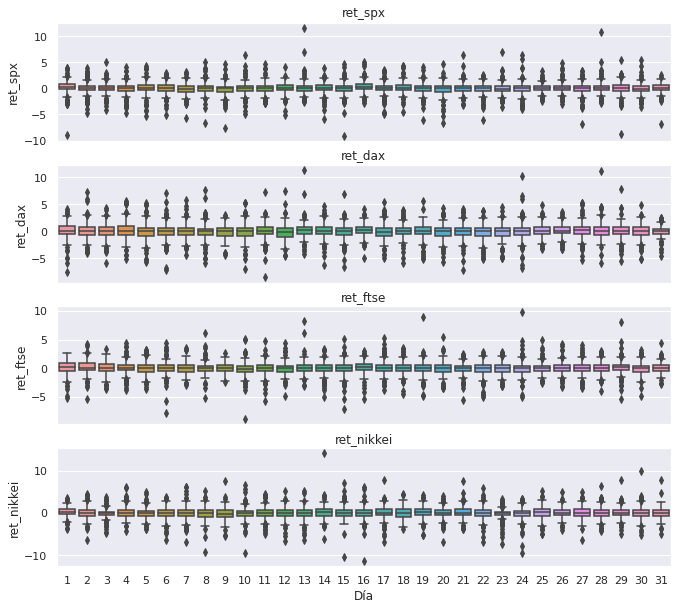

In [ ]:
import matplotlib.pyplot as mplt
import seaborn as sbn

df['Día']=df.index.day
df['Mes']=df.index.month

#Gráfico 1
fig, ejes = mplt.subplots(4, 1, figsize=(11, 10), sharex=True)
for nombre, eje in zip(['ret_spx','ret_dax','ret_ftse','ret_nikkei'], ejes):
    sbn.boxplot(data=df,x='Día',y=nombre,ax=eje)
    eje.set_title(nombre)
    if eje != ejes[-1]:
        eje.set_xlabel('')

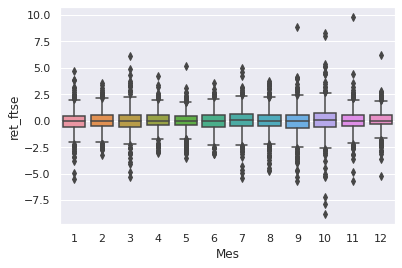

In [ ]:
#Grafico 2
sbn.boxplot(data=df, x='Mes', y='ret_ftse')

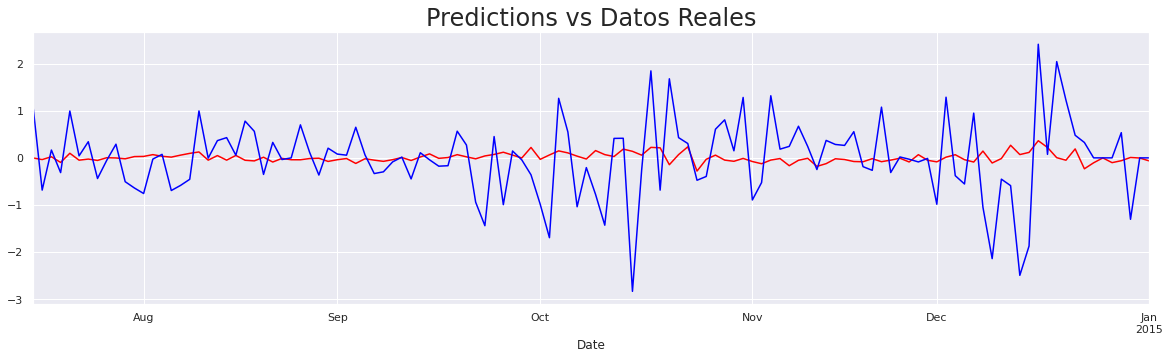

In [ ]:
#end_date = "2015-01-01"
#end_date = "2014-08-18"
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Datos Reales", size = 24)
plt.show()

#### SARIMAX

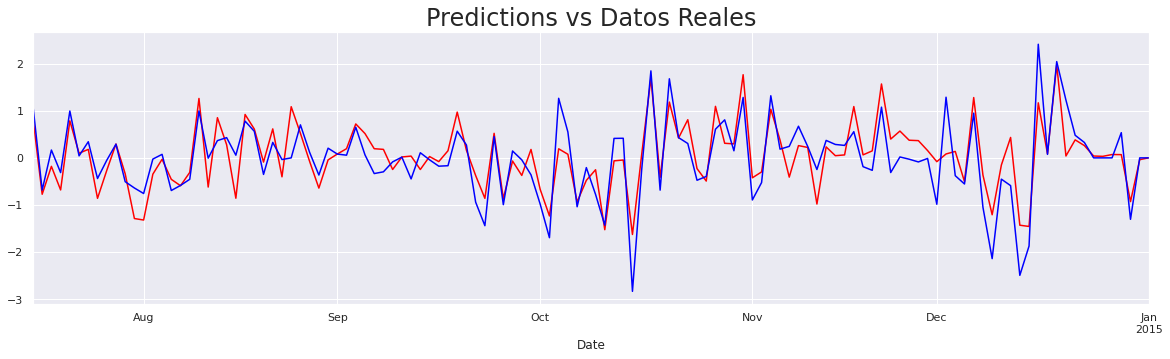

In [ ]:
end_date = "2015-01-01"
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()
df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Datos Reales", size = 24)
plt.show()

#### AUTOARIMA

In [ ]:
model_auto = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                       m = 5, max_p = 3, max_q = 3, max_P = 3, max_Q = 3)

In [24]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

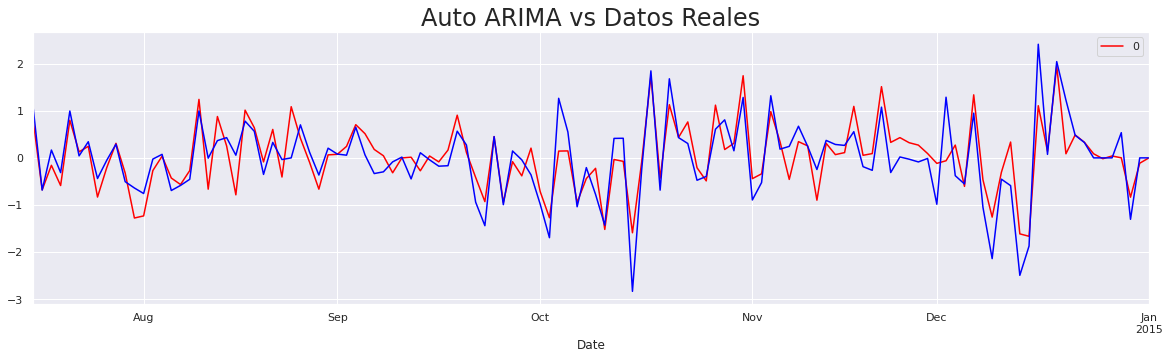

In [25]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto ARIMA vs Datos Reales", size = 24)
plt.show()

#### COMPARACIÓN

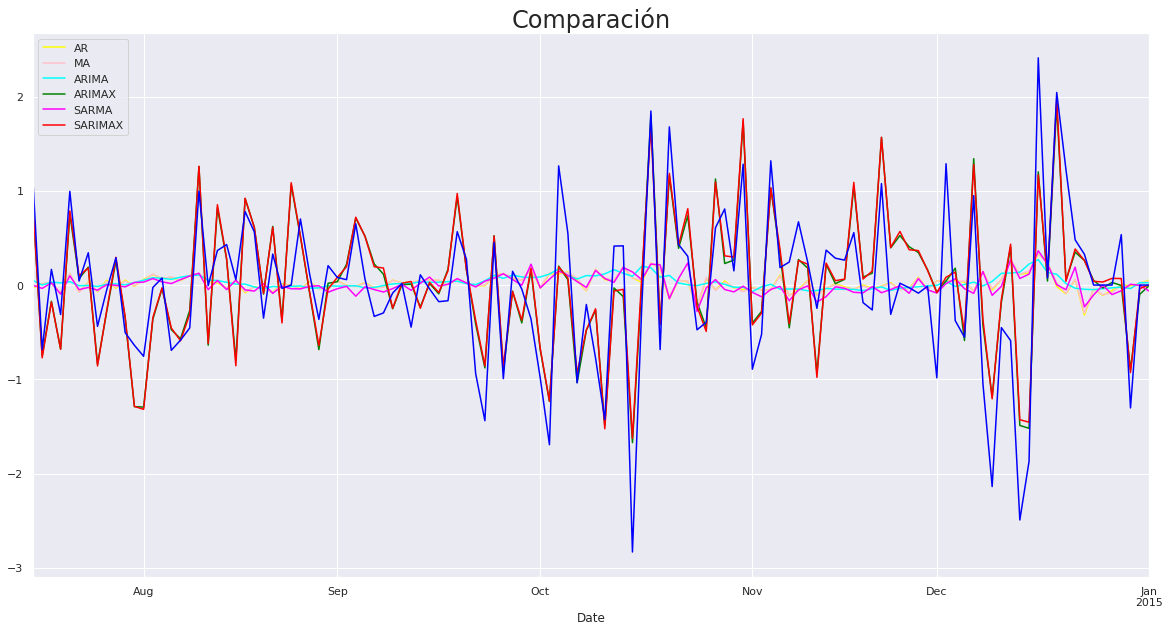

In [26]:
end_date = "2015-01-01"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARIMA','ARIMAX','SARMA','SARIMAX'])
plt.title("Comparación", size = 24)
plt.show()

#### GARCH

In [27]:
!pip install arch
from arch import arch_model

     |████████████████████████████████| 808kB 31.5MB/s 


In [28]:
# Crear Fechas (business days)
start_date = "2014-07-16"
end_date = "2015-01-01"

In [34]:
mod_garch = arch_model(df.ret_ftse[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     74,   Neg. LLF: 7311.064967249472
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7311.064229906422
            Iterations: 12
            Function evaluations: 86
            Gradient evaluations: 12


In [35]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

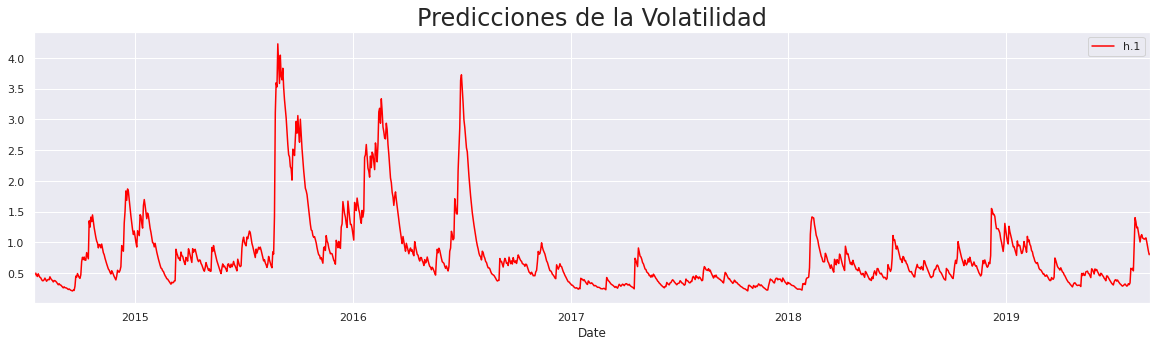

In [36]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
plt.title("Predicciones de la Volatilidad", size = 24)
plt.show()

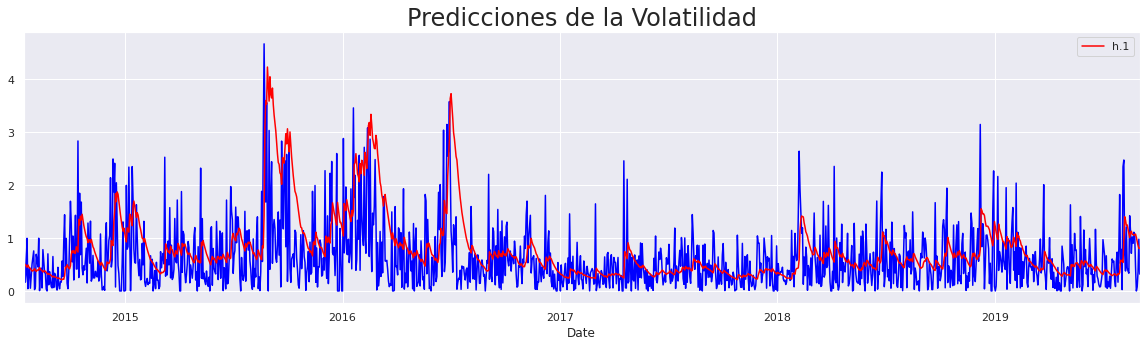

In [ ]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_ftse.abs().plot(color = "blue", zorder = 1)
plt.title("Predicciones de la Volatilidad", size = 24)
plt.show()

In [32]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred= pd.DataFrame(pred_garch.residual_variance[-1:])
pred


,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,h.011,h.012,h.013,h.014,h.015,h.016,h.017,h.018,h.019,h.020,h.021,h.022,h.023,h.024,h.025,h.026,h.027,h.028,h.029,h.030,h.031,h.032,h.033,h.034,h.035,h.036,h.037,h.038,h.039,h.040,...,h.061,h.062,h.063,h.064,h.065,h.066,h.067,h.068,h.069,h.070,h.071,h.072,h.073,h.074,h.075,h.076,h.077,h.078,h.079,h.080,h.081,h.082,h.083,h.084,h.085,h.086,h.087,h.088,h.089,h.090,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-08-30,0.811449,0.805648,0.867232,0.940608,1.02073,1.084989,1.074064,1.067783,1.08121,1.090608,1.142407,1.121338,1.036393,1.11072,1.183629,1.257723,1.248608,1.336788,1.395024,1.014502,0.65149,0.691586,0.683082,0.701209,0.509165,0.491619,0.510821,0.490371,0.49208,0.512208,0.531597,0.528003,0.524606,0.523109,0.536405,0.555709,0.569648,0.590162,0.609764,0.63289,...,0.779928,0.790801,0.816335,0.836243,0.860533,0.85355,0.873285,0.827,0.8511,0.878126,0.888177,0.808246,0.829919,0.85095,0.859692,0.883821,0.883548,0.883613,0.855375,0.8605,0.882306,0.865465,0.886742,0.777604,0.790476,0.798239,0.800314,0.802961,0.810827,0.823701,0.837281,0.838888,0.830292,0.815455,0.827095,0.839331,0.850645,0.864163,0.871725,0.886197
